Epoch 01: Loss=0.2392 | MAE=3.02 | Acc=93.15% | Precision=0.00% | Recall=0.00% | F1=0.00%
Epoch 02: Loss=0.2324 | MAE=2.56 | Acc=93.16% | Precision=66.67% | Recall=0.17% | F1=0.33%
Epoch 03: Loss=0.2277 | MAE=2.34 | Acc=93.35% | Precision=86.96% | Recall=3.32% | F1=6.40%
Epoch 04: Loss=0.2250 | MAE=2.53 | Acc=93.33% | Precision=74.24% | Recall=4.07% | F1=7.72%
Epoch 05: Loss=0.2220 | MAE=2.69 | Acc=93.36% | Precision=83.64% | Recall=3.82% | F1=7.31%
Epoch 06: Loss=0.2220 | MAE=2.52 | Acc=93.36% | Precision=89.13% | Recall=3.41% | F1=6.56%
Epoch 07: Loss=0.2216 | MAE=2.38 | Acc=93.32% | Precision=80.00% | Recall=3.32% | F1=6.38%
Epoch 08: Loss=0.2240 | MAE=2.54 | Acc=93.24% | Precision=60.26% | Recall=3.90% | F1=7.33%
Epoch 09: Loss=0.2200 | MAE=2.52 | Acc=93.38% | Precision=72.73% | Recall=5.32% | F1=9.91%
Epoch 10: Loss=0.2214 | MAE=2.49 | Acc=93.36% | Precision=81.03% | Recall=3.90% | F1=7.45%
Epoch 11: Loss=0.2181 | MAE=2.38 | Acc=93.38% | Precision=60.75% | Recall=9.39% | F1=16.26%

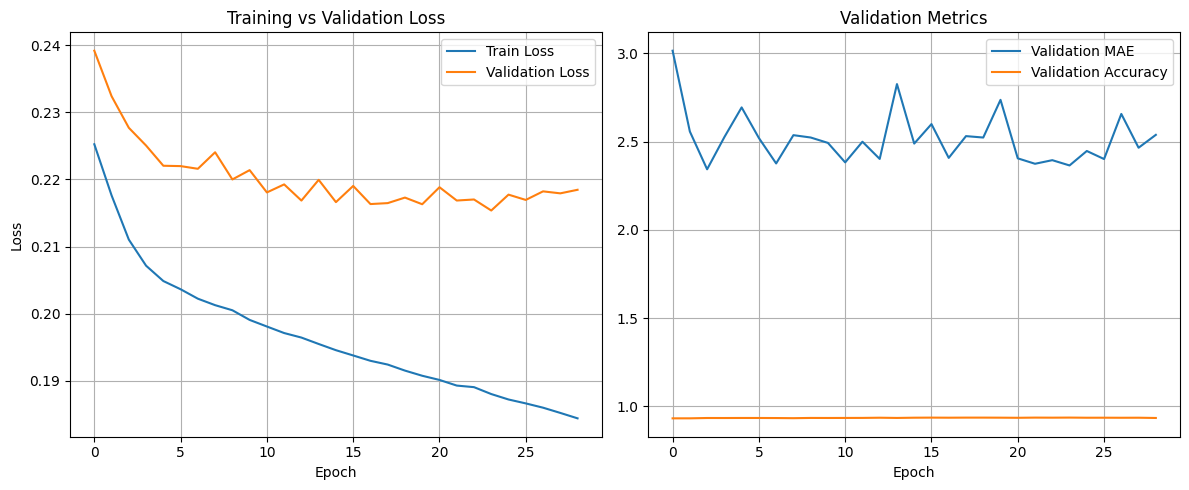

📤 Predictions saved to predictions_after_training.csv


C:\Users\moata\AppData\Local\Temp\ipykernel_20884\1267302235.py:194: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary['MAE'] = grouped.apply(


📊 Per-CHUTE/ZIP summary saved to per_chute_zip_summary.csv


C:\Users\moata\AppData\Local\Temp\ipykernel_20884\1267302235.py:198: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary['Accuracy'] = grouped.apply(


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

# 1. Load and prepare data
df = pd.read_csv("./DATA/data1day_new.csv")
df['HOUR_TIME'] = pd.to_datetime(df['HOUR_TIME'])

df['CHUTE'] = df['CHUTE'].astype('category').cat.codes
df['ZIP_CODE'] = df['ZIP_CODE'].astype('category').cat.codes
df = df.sort_values(by=['CHUTE', 'ZIP_CODE', 'HOUR_TIME']).reset_index(drop=True)

# 2. Define features and targets
features = [
    'CODS_ZENT_NR', 'CHUTE', 'ZIP_CODE', 'PACKAGE_COUNT',
    'CHUTE_LOAD', 'ZIP_PACKAGE_COUNT', 'HOUR_OF_DAY', 'DAY_OF_WEEK'
]
target_reg = 'AVG_PROCESSING_TIME_MINUTES'
target_cls = 'PERFORMANCE_ISSUE'  # ← Use directly from CSV

# 3. Normalize
feature_scaler = MinMaxScaler()
df[features] = feature_scaler.fit_transform(df[features])
target_scaler = MinMaxScaler()
df[[target_reg]] = target_scaler.fit_transform(df[[target_reg]])

# 4. Create sequences
def create_sequences(data, target_reg_idx, target_cls_idx, seq_len=5):
    X, y_reg, y_cls = [], [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-2])
        y_reg.append(data[i+seq_len, target_reg_idx])
        y_cls.append(data[i+seq_len, target_cls_idx])
    return np.array(X), np.array(y_reg), np.array(y_cls)

data = df[features + [target_reg, target_cls]].values
X, y_reg, y_cls = create_sequences(data, len(features), len(features)+1)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_reg_tensor = torch.tensor(y_reg, dtype=torch.float32)
y_cls_tensor = torch.tensor(y_cls, dtype=torch.float32)

# 5. Create Datasets
dataset = TensorDataset(X_tensor, y_reg_tensor, y_cls_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

# 6. Define Model
class LSTMHybrid(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc_reg = nn.Linear(hidden_size, 1)
        self.fc_cls = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc_reg(out), self.sigmoid(self.fc_cls(out))

model = LSTMHybrid(input_size=X.shape[2])
criterion_reg = nn.MSELoss()
criterion_cls = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 7. Train with metrics and early stopping
train_losses, val_losses = [], []
val_mae_scores, val_acc_scores = [], []
best_val_loss = float("inf")
best_model_state = None
patience = 5
wait = 0

for epoch in range(50):  # Train up to 50 epochs
    model.train()
    train_loss = 0
    for xb, yb_reg, yb_cls in train_loader:
        optimizer.zero_grad()
        out_reg, out_cls = model(xb)
        loss = criterion_reg(out_reg.view(-1), yb_reg) + criterion_cls(out_cls.view(-1), yb_cls)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    y_reg_preds, y_cls_preds = [], []
    y_reg_true, y_cls_true = [], []

    with torch.no_grad():
        for xb, yb_reg, yb_cls in val_loader:
            out_reg, out_cls = model(xb)
            loss = criterion_reg(out_reg.view(-1), yb_reg) + criterion_cls(out_cls.view(-1), yb_cls)
            val_loss += loss.item()

            y_reg_preds.extend(out_reg.view(-1).numpy())
            y_cls_preds.extend(out_cls.view(-1).numpy())
            y_reg_true.extend(yb_reg.numpy())
            y_cls_true.extend(yb_cls.numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_mae = mean_absolute_error(
        target_scaler.inverse_transform(np.array(y_reg_true).reshape(-1, 1)),
        target_scaler.inverse_transform(np.array(y_reg_preds).reshape(-1, 1))
    )
    val_acc = accuracy_score(y_cls_true, np.array(y_cls_preds) > 0.5)
    val_precision = precision_score(y_cls_true, np.array(y_cls_preds) > 0.5, zero_division=0)
    val_recall = recall_score(y_cls_true, np.array(y_cls_preds) > 0.5, zero_division=0)
    val_f1 = f1_score(y_cls_true, np.array(y_cls_preds) > 0.5, zero_division=0)

    val_mae_scores.append(val_mae)
    val_acc_scores.append(val_acc)

    print(f"Epoch {epoch+1:02}: Loss={val_loss:.4f} | MAE={val_mae:.2f} | "
          f"Acc={val_acc:.2%} | Precision={val_precision:.2%} | Recall={val_recall:.2%} | F1={val_f1:.2%}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("⏹️ Early stopping triggered.")
            break

# 8. Save best model
torch.save(best_model_state, "best_lstm_hybridv3.pt")
print("✅ Best model saved.")

# 9. Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(val_mae_scores, label="Validation MAE")
plt.plot(val_acc_scores, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.title("Validation Metrics")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# 10. Inference and export predictions on full dataset
model.load_state_dict(best_model_state)
model.eval()

X_full_tensor = torch.tensor(X, dtype=torch.float32)
with torch.no_grad():
    y_pred_reg, y_pred_cls = model(X_full_tensor)
    predicted_time = target_scaler.inverse_transform(
        y_pred_reg.view(-1).reshape(-1, 1)
    ).flatten()
    predicted_flag = (y_pred_cls.view(-1).numpy() > 0.5).astype(int)

output_df = df.iloc[5:].copy().reset_index(drop=True)
output_df['Predicted_Processing_Time'] = predicted_time
output_df['Predicted_Performance_Issue'] = predicted_flag
output_df.to_csv("predictions_after_training.csv", index=False)
print("📤 Predictions saved to predictions_after_training.csv")

# 11. Per-CHUTE and ZIP evaluation
grouped = output_df.groupby(['CHUTE', 'ZIP_CODE'])

summary = grouped.agg({
    'AVG_PROCESSING_TIME_MINUTES': 'mean',
    'Predicted_Processing_Time': 'mean',
    'PERFORMANCE_ISSUE': 'sum',
    'Predicted_Performance_Issue': 'sum'
}).reset_index()

summary['MAE'] = grouped.apply(
    lambda g: mean_absolute_error(g['AVG_PROCESSING_TIME_MINUTES'], g['Predicted_Processing_Time'])
).values

summary['Accuracy'] = grouped.apply(
    lambda g: accuracy_score(g['PERFORMANCE_ISSUE'], g['Predicted_Performance_Issue'])
).values

summary.to_csv("per_chute_zip_summary.csv", index=False)
print("📊 Per-CHUTE/ZIP summary saved to per_chute_zip_summary.csv")


In [2]:
def predict_and_compare_at_time(df_raw, target_time, model, feature_scaler, target_scaler, seq_len=5):
    # Ensure datetime and sort order
    df_raw['HOUR_TIME'] = pd.to_datetime(df_raw['HOUR_TIME'])
    df = df_raw[df_raw['HOUR_TIME'] <= pd.to_datetime(target_time)]
    df = df.sort_values(by=['CHUTE', 'ZIP_CODE', 'HOUR_TIME']).reset_index(drop=True)

    # Collect predictions per CHUTE
    results = []

    for chute in df['CHUTE'].unique():
        chute_df = df[df['CHUTE'] == chute].copy()
        chute_df = chute_df.sort_values(by='HOUR_TIME')

        if len(chute_df) < seq_len:
            continue

        last_seq = chute_df.iloc[-seq_len:].copy()

        # Encode as in training
        last_seq['CHUTE'] = last_seq['CHUTE'].astype('category').cat.codes
        last_seq['ZIP_CODE'] = last_seq['ZIP_CODE'].astype('category').cat.codes

        # Scale features
        last_seq[features] = feature_scaler.transform(last_seq[features])

        # Prepare input tensor
        x_seq = torch.tensor([last_seq[features].values], dtype=torch.float32)

        # Predict
        with torch.no_grad():
            y_pred_reg, y_pred_cls = model(x_seq)
            predicted_time = target_scaler.inverse_transform(
                y_pred_reg.view(-1).reshape(-1, 1)
            ).flatten()[0]
            predicted_issue = int(y_pred_cls.view(-1).item() > 0.5)

        # Get actual values
        latest = chute_df.iloc[-1]
        actual_time = latest['AVG_PROCESSING_TIME_MINUTES']
        actual_issue = latest['PERFORMANCE_ISSUE']
        zip_code = latest['ZIP_CODE']
        hour = latest['HOUR_TIME']

        results.append({
            'Time': hour,
            'CHUTE': chute,
            'ZIP_CODE': zip_code,
            'Actual_Processing_Time': actual_time,
            'Predicted_Processing_Time': predicted_time,
            'Actual_Performance_Issue': actual_issue,
            'Predicted_Performance_Issue': predicted_issue
        })

    result_df = pd.DataFrame(results)
    return result_df


In [5]:
# Load 1-day dataset
df = pd.read_csv("./DATA/data1day_new.csv")

# Run predictions at a specific timestamp
result_df = predict_and_compare_at_time(
    df_raw=df,
    target_time="2025-03-24 19:00",  # Change to your timestamp
    model=model,
    feature_scaler=feature_scaler,
    target_scaler=target_scaler,
    seq_len=5
)

print(result_df)


C:\Users\moata\AppData\Local\Temp\ipykernel_20884\4273657258.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  x_seq = torch.tensor([last_seq[features].values], dtype=torch.float32)


                   Time  CHUTE  ZIP_CODE  Actual_Processing_Time  \
0   2025-03-24 16:00:00  R0101    120500                1.316667   
1   2025-03-24 16:00:00  R0102    946600                1.738889   
2   2025-03-24 16:00:00  R0103    678000               -2.716667   
3   2025-03-24 16:00:00  R0104    192000                0.925758   
4   2025-03-24 16:00:00  R0105    949800                1.183333   
..                  ...    ...       ...                     ...   
351 2025-03-24 16:00:00  R3525    644000                5.902381   
352 2025-03-24 16:00:00  R3526    642300                5.316667   
353 2025-03-24 16:00:00  R5101    111000                1.811111   
354 2025-03-24 16:00:00  R5102    601400                2.400000   
355 2025-03-24 16:00:00  R5103    120900                1.583333   

     Predicted_Processing_Time  Actual_Performance_Issue  \
0                     3.084412                         0   
1                     5.563318                         0   
2  

In [4]:
print(df['HOUR_TIME'].min(), df['HOUR_TIME'].max())


2025-03-24 06:00:00 2025-03-24 16:00:00


In [9]:
def scan_and_predict_issues(df_raw, model, feature_scaler, target_scaler, seq_len=5):
    df_raw['HOUR_TIME'] = pd.to_datetime(df_raw['HOUR_TIME'])
    df_raw = df_raw.sort_values(by=['CHUTE', 'ZIP_CODE', 'HOUR_TIME']).reset_index(drop=True)

    results = []

    # Loop through actual issue points
    issue_points = df_raw[df_raw['PERFORMANCE_ISSUE'] == 1]

    for idx, row in issue_points.iterrows():
        chute = row['CHUTE']
        time = row['HOUR_TIME']

        # Get past sequence for that chute
        chute_df = df_raw[(df_raw['CHUTE'] == chute) & (df_raw['HOUR_TIME'] <= time)]
        chute_df = chute_df.sort_values(by='HOUR_TIME')

        if len(chute_df) < seq_len:
            continue  # Not enough history

        seq_df = chute_df.iloc[-seq_len:].copy()

        # Encode CHUTE & ZIP as category codes (as in training)
        seq_df['CHUTE'] = seq_df['CHUTE'].astype('category').cat.codes
        seq_df['ZIP_CODE'] = seq_df['ZIP_CODE'].astype('category').cat.codes

        # Scale input features
        seq_df[features] = feature_scaler.transform(seq_df[features])

        # Predict
        x_seq = torch.tensor([seq_df[features].values], dtype=torch.float32)
        with torch.no_grad():
            y_pred_reg, y_pred_cls = model(x_seq)

            # ✅ Inverse transform regression output to get prediction in minutes
            pred_time = target_scaler.inverse_transform(
                y_pred_reg.view(-1).reshape(-1, 1)
            ).flatten()[0]

            # Classification threshold
            pred_prob = y_pred_cls.view(-1).item()
            pred_issue = int(pred_prob > 0.5)

        results.append({
            'HOUR_TIME': time,
            'CHUTE': chute,
            'ZIP_CODE': row['ZIP_CODE'],
            'Actual_Processing_Time': row['AVG_PROCESSING_TIME_MINUTES'],
            'Predicted_Processing_Time': pred_time,
            'Actual_Performance_Issue': row['PERFORMANCE_ISSUE'],
            'Predicted_Performance_Issue': pred_issue,
            'Predicted_Issue_Probability': pred_prob  # Optional insight
        })

    return pd.DataFrame(results)


In [10]:
df = pd.read_csv("./DATA/data1day_new.csv")

issue_preds = scan_and_predict_issues(
    df_raw=df,
    model=model,
    feature_scaler=feature_scaler,
    target_scaler=target_scaler,
    seq_len=5
)

print(issue_preds.head())


            HOUR_TIME  CHUTE  ZIP_CODE  Actual_Processing_Time  \
0 2025-03-24 09:00:00  R0101    100026               13.383333   
1 2025-03-24 11:00:00  R0101    100802               11.516667   
2 2025-03-24 11:00:00  R0101    102602               13.650000   
3 2025-03-24 11:00:00  R0101    102800               14.850000   
4 2025-03-24 15:00:00  R0101    103200               10.866667   

   Predicted_Processing_Time  Actual_Performance_Issue  \
0                   0.422696                         1   
1                   2.839476                         1   
2                   2.839476                         1   
3                   2.839476                         1   
4                   1.411401                         1   

   Predicted_Performance_Issue  Predicted_Issue_Probability  
0                            0                     0.008698  
1                            0                     0.011310  
2                            0                     0.011310  
3     

🔴 2. Wrong Predicted_Performance_Issue (always 0)
If all Predicted_Performance_Issue = 0, then:

The sigmoid output < 0.5 for all samples

Model is not confident that the issue is happening, possibly due to:

Imbalanced data (many more 0s than 1s)

Not enough examples like this in training

LSTM not capturing spike patterns